In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
!pip install pandas numpy scikit-learn nltk spacy contractions emoji



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 8.9 MB/s eta 0:00:00


In [8]:
!python -m nltk.downloader stopwords
!python -m spacy download en_core_web_sm

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
import contractions
import emoji
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

# Loading spaCy model
nlp = spacy.load("en_core_web_sm")

# Loading dataset
df = pd.read_excel("/content/drive/MyDrive/Research practicum dataset/drugLibTrain_raw.xls")

In [10]:

# Combining all reviews into one column
df["full_review"] = df["benefitsReview"].fillna('') + " " + df["sideEffectsReview"].fillna('') + " " + df["commentsReview"].fillna('')


In [11]:
# Text cleaner
def clean_text(text):
    text = str(text)
    text = contractions.fix(text)
    text = emoji.replace_emoji(text, replace='')
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Applying cleaning
df["clean_review"] = df["full_review"].apply(clean_text)

In [12]:
# Removing stopwords and lemmatizing
stop_words = set(stopwords.words("english"))

def spacy_lemmatizer(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha])

df["lemmatized_review"] = df["clean_review"].apply(spacy_lemmatizer)

# Encoding Categorical Columns
label_encoders = {}
for col in ["effectiveness", "sideEffects", "condition"]:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [31]:
# Checking the encoding
label_encoders['effectiveness'].classes_

array(['Considerably Effective', 'Highly Effective', 'Ineffective',
       'Marginally Effective', 'Moderately Effective'], dtype=object)

In [13]:
!pip install spacy negspacy
!python -m spacy download en_core_web_sm


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for negspacy: filename=negspacy-1.0.4-py3-none-any.whl size=12631 sha256=cf1f13ab0f9d7f997cb52e97910415596857d5500c2658568ac2bd00facc8bf3
  Stored in directory: /root/.cache/pip/wheels/f6/f9/97/c64705a59cd428402beb3aaa09acfba585e8678173337c45d3
Successfully built negspacy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
#Flaging ADR if sideEffectsReview contains known adverse words or use thresholds
adr_keywords = ["rash", "nausea", "vomiting", "bleeding", "pain", "swelling", "seizure", "dizziness", "hallucination"]

def detect_adr(text):
    text = text.lower()
    return int(any(word in text for word in adr_keywords))

df["ADR_Label"] = df["sideEffectsReview"].apply(lambda x: detect_adr(str(x)))

# Final dataset
final_df = df[["urlDrugName", "rating", "effectiveness", "sideEffects", "condition", "lemmatized_review", "ADR_Label"]]

In [15]:
# Handling negations
import spacy

# Loading spaCy model
nlp = spacy.load("en_core_web_sm")

adr_keywords = set(["rash", "nausea", "vomiting", "bleeding", "pain", "swelling", "seizure", "dizziness", "hallucination"])

NEGATIONS = {"neg"}

def is_negated(token):
    # Check if token has negation children
    if any(child.dep_ in NEGATIONS for child in token.children):
        return True
    # Check ancestors for negation
    for ancestor in token.ancestors:
        if any(child.dep_ in NEGATIONS for child in ancestor.children):
            return True
    return False

def detect_adr_with_negation(text):
    doc = nlp(text.lower())
    for token in doc:
        if token.lemma_ in adr_keywords:
            if not is_negated(token):
                return 1  # ADR found and not negated
    return 0  # No ADR found or all negated


In [16]:
df["ADR_Label"] = df["sideEffectsReview"].fillna("").apply(detect_adr_with_negation)


In [17]:
# Final dataset
final_df = df[["urlDrugName", "rating", "effectiveness", "sideEffects", "condition", "lemmatized_review", "ADR_Label"]]

In [18]:
final_df.head()

,urlDrugName,rating,effectiveness,sideEffects,condition,lemmatized_review,ADR_Label
0,enalapril,4,1,1,797,slow progression left ventricular dysfunction ...,0
1,ortho-tri-cyclen,1,1,4,224,although type birth control con pro help cramp...,0
2,ponstel,10,1,3,819,use cramp badly would leave ball bed least day...,0
3,prilosec,3,3,1,11,acid reflux go away month day drug heartburn s...,1
4,lyrica,2,3,4,492,think lyrica start help pain side effect sever...,0


In [19]:
# Example of a record
pd.set_option('display.max_colwidth', None)
final_df.loc[2]

,2
urlDrugName,ponstel
rating,10
effectiveness,1
sideEffects,3
condition,819
lemmatized_review,use cramp badly would leave ball bed least day ponstel take pain away completely take edge much normal activity possible definitely miracle medication heavy bleeding clotting normal take pill onset menstrual cramp every hour take pill need day cramp cramp bad make sure take every hour dot medication stop work suddenly unfortunately take hour hour half kick back cramp moderate take every hour okay
ADR_Label,0


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# TF-IDF Vectorizer for review text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df["lemmatized_review"])

# Numeric features
X_numeric = df[["rating", "effectiveness", "sideEffects", "condition"]]

# Combining text and numeric features
from scipy.sparse import csr_matrix
X_combined = hstack([csr_matrix(X_numeric.values), X_text])

# Labels
y = df["ADR_Label"]


In [21]:
X_combined.shape

(3107, 5004)

In [22]:
y.shape

(3107,)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


Random Forest and XGBoost models

In [24]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("Random Forest:\n", classification_report(y_test, rf_preds))

# XGBoost
xgb_model = XGBClassifier(scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1])), eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("XGBoost:\n", classification_report(y_test, xgb_preds))


Random Forest:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       540
           1       0.85      0.21      0.33        82

    accuracy                           0.89       622
   macro avg       0.87      0.60      0.64       622
weighted avg       0.89      0.89      0.86       622

XGBoost:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       540
           1       0.70      0.77      0.73        82

    accuracy                           0.93       622
   macro avg       0.83      0.86      0.84       622
weighted avg       0.93      0.93      0.93       622



XAI Implementation for the  Ensemble model

Tree Interpreter


In [25]:
!pip install treeinterpreter

In [27]:
from treeinterpreter import treeinterpreter as ti
import numpy as np

# Predicting with Tree Interpreter
prediction, bias, contributions = ti.predict(rf_model, X_test)

# Explaining prediction for first instance and class 1 (ADR)
instance_index = 0
class_idx = 1  # ADR class

instance_contribs = contributions[instance_index][:, class_idx]

# Getting feature names
numeric_feature_names = ["rating", "effectiveness", "sideEffects", "condition"]
text_feature_names = tfidf.get_feature_names_out()
all_feature_names = numeric_feature_names + list(text_feature_names)

print("Prediction:", prediction[instance_index][class_idx])
print("Bias (average prediction):", bias[instance_index][class_idx])
print(f"\nNon-zero Feature Contributions for class {class_idx}:")

# Printing only non-zero contributors
for i, c in enumerate(instance_contribs):
    if c != 0:
        direction = "↑" if c > 0 else "↓"
        feature_name = all_feature_names[i]
        print(f"{feature_name:30} {direction} {c:.4f}")


Prediction: 0.15000000000000005
Bias (average prediction): 0.4998838226909496

Non-zero Feature Contributions for class 1:
rating                         ↑ 0.0074
effectiveness                  ↓ -0.0053
sideEffects                    ↓ -0.0034
condition                      ↑ 0.0010
abdominal                      ↓ -0.0012
abdominal pain                 ↓ -0.0013
able                           ↑ 0.0013
able function                  ↓ -0.0001
able go                        ↓ -0.0001
able handle                    ↓ -0.0000
able work                      ↓ -0.0001
accompany                      ↓ -0.0001
ace                            ↓ -0.0001
ache                           ↓ -0.0001
acid                           ↓ -0.0001
acid reflux                    ↑ 0.0000
acne                           ↑ 0.0003
acne face                      ↓ -0.0001
acne take                      ↑ 0.0004
act                            ↓ -0.0000
activity                       ↑ 0.0013
actonel                

In [28]:
# Finding the top contributors
import pandas as pd

# Creating a DataFrame for all contributions
df_contrib = pd.DataFrame({
    'Feature': all_feature_names,
    'Contribution': instance_contribs
})

# Filtering out zero contributions and sorting by absolute value
df_significant = df_contrib[df_contrib['Contribution'] != 0].copy()
df_significant['AbsContribution'] = df_significant['Contribution'].abs()
df_significant['Direction'] = df_significant['Contribution'].apply(lambda x: '↑' if x > 0 else '↓')

# Getting top 20 contributors to ADR prediction
top_n = 20
df_top_contributors = df_significant.sort_values(by='AbsContribution', ascending=False).head(top_n)

# Display or return the results
print("\nTop Significant Feature Contributors to ADR (Class 1):\n")
print(df_top_contributors[['Feature', 'Direction', 'Contribution']].to_string(index=False))



Top Significant Feature Contributors to ADR (Class 1):

    Feature Direction  Contribution
    seizure         ↑      0.045622
       pain         ↓     -0.042211
     nausea         ↓     -0.036379
  everytime         ↑      0.018999
  dizziness         ↓     -0.017682
      tired         ↑      0.015557
       dose         ↑      0.010686
       high         ↓     -0.010630
       food         ↑      0.010405
      sleep         ↓     -0.009190
       pill         ↓     -0.009012
       rash         ↓     -0.008509
  could get         ↓     -0.008213
   increase         ↑      0.007597
     system         ↓     -0.007540
     rating         ↑      0.007393
entire body         ↓     -0.007384
     severe         ↓     -0.006328
       long         ↑      0.006279
        eat         ↓     -0.006208


Partial Dependence plots

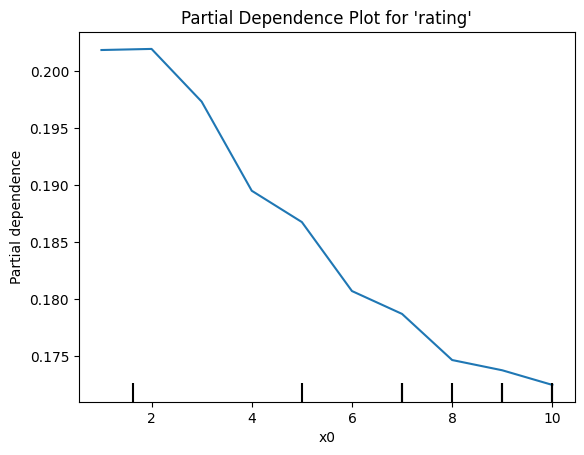

In [29]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Converting sparse matrix to dense
X_test_dense = X_test.toarray()

PartialDependenceDisplay.from_estimator(rf_model, X_test_dense, features=[0])
plt.title("Partial Dependence Plot for 'rating'")
plt.show()


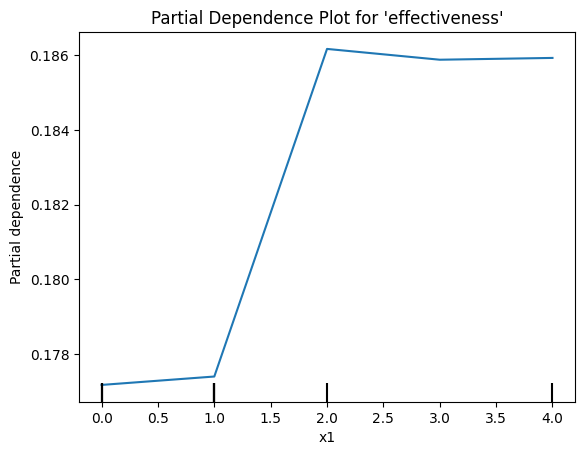

In [30]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Converting sparse matrix to dense
X_test_dense = X_test.toarray()

PartialDependenceDisplay.from_estimator(rf_model, X_test_dense, features=[1])
plt.title("Partial Dependence Plot for 'effectiveness'")
plt.show()


LSTM

In [32]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


# LSTM
print("\n" + "="*50)
print("TRAINING LSTM MODEL")
print("="*50)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Enhanced tokenization
tokenizer = Tokenizer(
    num_words=15000,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
tokenizer.fit_on_texts(df["lemmatized_review"])
sequences = tokenizer.texts_to_sequences(df["lemmatized_review"])

# Dynamic maxlen based on data (used 90th percentile)
sequence_lengths = [len(seq) for seq in sequences]
maxlen = int(np.percentile(sequence_lengths, 90))
print(f"Sequence length stats - Mean: {np.mean(sequence_lengths):.1f}, 90th percentile: {maxlen}")

# Padding sequences
X_seq = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = df["ADR_Label"].values

# Stratified train-test split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set - ADR: {y_train_seq.sum()}, No ADR: {(y_train_seq == 0).sum()}")
print(f"Test set - ADR: {y_test_seq.sum()}, No ADR: {(y_test_seq == 0).sum()}")

# Calculating class weights
class_weights_sklearn = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train_seq), y=y_train_seq
)
class_weights_dict = {0: class_weights_sklearn[0], 1: class_weights_sklearn[1]}
print(f"Class weights: {class_weights_dict}")

# Building the LSTM model
vocab_size = min(15000, len(tokenizer.word_index) + 1)
print(f"Vocabulary size: {vocab_size}")

model = Sequential([
    # Embedding layer with masking for padded sequences
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen, mask_zero=True),

    # Spatial dropout for embedding layer
    SpatialDropout1D(0.3),

    # First bidirectional LSTM layer (returns sequences)
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),

    # Second bidirectional LSTM layer (final output)
    Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),

    # Dense layers with dropout for classification
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compiling model with custom optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', 'precision', 'recall']
)

print(model.summary())

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Training model with class weights
print("Training LSTM model...")
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

# Getting prediction probabilities
y_pred_probs = model.predict(X_test_seq)

# Testing different thresholds to find optimal one
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
best_f1 = 0
best_threshold = 0.5

print("\nTesting different thresholds:")
print("Threshold | Precision | Recall | F1-Score")
print("-" * 45)

for threshold in thresholds:
    y_pred_thresh = (y_pred_probs > threshold).astype(int).flatten()
    report = classification_report(y_test_seq, y_pred_thresh, output_dict=True)

    if '1' in report:  # Check if class 1 exists in predictions
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1_score = report['1']['f1-score']
    else:
        precision = recall = f1_score = 0.0

    print(f"{threshold:9.1f} | {precision:9.3f} | {recall:6.3f} | {f1_score:8.3f}")

    if f1_score > best_f1:
        best_f1 = f1_score
        best_threshold = threshold

print(f"\nBest threshold: {best_threshold} (F1-score: {best_f1:.3f})")

# Final predictions with best threshold
y_pred_final = (y_pred_probs > best_threshold).astype(int).flatten()

print(f"\nFinal LSTM Results (threshold={best_threshold}):")
print(classification_report(y_test_seq, y_pred_final))



TRAINING ENHANCED LSTM MODEL
Sequence length stats - Mean: 60.9, 90th percentile: 107
Training set - ADR: 421, No ADR: 2064
Test set - ADR: 105, No ADR: 517
Class weights: {0: np.float64(0.6019864341085271), 1: np.float64(2.951306413301663)}
Vocabulary size: 10677


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Training LSTM model...
Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 793ms/step - accuracy: 0.5879 - loss: 0.6765 - precision: 0.1542 - recall: 0.3508 - val_accuracy: 0.1704 - val_loss: 0.7188 - val_precision: 0.1691 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 740ms/step - accuracy: 0.4349 - loss: 0.6696 - precision: 0.2010 - recall: 0.7770 - val_accuracy: 0.7894 - val_loss: 0.5647 - val_precision: 0.4207 - val_recall: 0.6571 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 715ms/step - accuracy: 0.8617 - loss: 0.4220 - precision: 0.5731 - recall: 0.8452 - val_accuracy: 0.7492 - val_loss: 0.5577 - val_precision: 0.3791 - val_recall: 0.7619 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 28s 727ms/step - accuracy: 0.9137 - loss: 0.2419 - precision: 0.6963 - recall: 0.9448 - val_accuracy: 0.8650 - val_loss: 0.3651 - val_precision: 0.5897 - val_recall: 0.6571 - learning_rate: 0.0010
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━

Explainable AI Integration

LIME

In [33]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a22d17fe3c862fcdf28932a28bc3dbb6e5c13907d986cfb240032c7a15dd6ff6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [34]:
from lime.lime_text import LimeTextExplainer
import numpy as np

class_names = ['No ADR', 'ADR']

# Wrapping model prediction function to accept raw text and return probability for each class
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=200)
    probs = model.predict(padded)
    # Return probabilities for both classes: [prob_no_adr, prob_adr]
    probs_2class = np.hstack([1 - probs, probs])
    return probs_2class

explainer = LimeTextExplainer(class_names=class_names)

# Picking the sample text at index 0 to explain
idx = 0
text_instance = df["lemmatized_review"].iloc[idx]

exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)

# Print explanation
print(f"Document id: {idx}")
print(f"Prediction probabilities: {predict_proba([text_instance])}")
print("Top features influencing prediction:")
print(exp.as_list())



157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step
Document id: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Prediction probabilities: [[0.95149153 0.04850849]]
Top features influencing prediction:
[(np.str_('failure'), -0.07129844613281817), (np.str_('slow'), -0.03447382170224615), (np.str_('tachycardia'), -0.031217134871282082), (np.str_('weakness'), 0.029759986879382992), (np.str_('congestive'), -0.025994208792363836), (np.str_('angina'), -0.0216945568295629), (np.str_('ass'), -0.020930977699567234), (np.str_('renal'), 0.013590157123473447), (np.str_('heart'), 0.0068098952113908135), (np.str_('dysfunction'), 0.005906419076027112)]


In [35]:
# Few more examples

from lime.lime_text import LimeTextExplainer
import numpy as np

# Define class names
class_names = ['No ADR', 'ADR']

MAXLEN_ENHANCED = maxlen  # Selecting the dynamic maxlen from your LSTM

# Wraping model prediction function to accept raw text and return probability for each class
def predict_proba_enhanced_lstm(texts):


    sequences = tokenizer.texts_to_sequences(texts)

    padded = pad_sequences(sequences, maxlen=MAXLEN_ENHANCED, padding='post', truncating='post')

    probs = model.predict(padded, verbose=0)  # verbose=0 to reduce output

    # Returning probabilities for both classes: [prob_no_adr, prob_adr]
    # LIME expects probabilities for ALL classes
    probs_2class = np.hstack([1 - probs, probs])
    return probs_2class

# Verifying the prediction function works correctly
print("Testing prediction function...")
sample_text = df["lemmatized_review"].iloc[0]
test_pred = predict_proba_enhanced_lstm([sample_text])
print(f"Sample prediction shape: {test_pred.shape}")
print(f"Sample prediction: {test_pred}")
print(f"Probabilities sum to 1: {np.allclose(test_pred.sum(axis=1), 1.0)}")

# Initializing LIME explainer
explainer = LimeTextExplainer(
    class_names=class_names
)

# Sample instances to explain
sample_indices = [0, 1, 2]

print("\n" + "="*60)
print("LIME EXPLANATIONS FOR ENHANCED LSTM MODEL")
print("="*60)

for idx in sample_indices:
    text_instance = df["lemmatized_review"].iloc[idx]
    actual_label = df["ADR_Label"].iloc[idx]

    print(f"\n--- Document ID: {idx} ---")
    print(f"Text preview: {text_instance[:200]}...")

    # Getting model prediction
    pred_probs = predict_proba_enhanced_lstm([text_instance])
    predicted_class = np.argmax(pred_probs[0])
    confidence = pred_probs[0][predicted_class]

    print(f"Prediction probabilities: No ADR={pred_probs[0][0]:.3f}, ADR={pred_probs[0][1]:.3f}")
    print(f"Confidence: {confidence:.3f}")

    # Generating LIME explanation
    print("\nGenerating LIME explanation...")
    exp = explainer.explain_instance(
        text_instance,
        predict_proba_enhanced_lstm,
        num_features=10,  # Show top 10 features
        num_samples=1000  # Number of samples for LIME
    )

    # Printing explanation
    print("Top features influencing prediction:")
    feature_list = exp.as_list()
    for feature, weight in feature_list:
        direction = "→ ADR" if weight > 0 else "→ No ADR"
        print(f"  '{feature}': {weight:+.3f} {direction}")

    # Showing explanation for specific class (ADR class)
    print(f"\nFeatures supporting ADR prediction:")
    for feature, weight in feature_list:
        if weight > 0:  # Positive weights support ADR
            print(f"  '{feature}': {weight:+.3f}")

    print("-" * 50)

Testing prediction function...
Sample prediction shape: (1, 2)
Sample prediction: [[0.95149153 0.04850849]]
Probabilities sum to 1: True

LIME EXPLANATIONS FOR ENHANCED LSTM MODEL

--- Document ID: 0 ---
Text preview: slow progression left ventricular dysfunction overt heart failure alone agent managment hypertension mangagement congestive heart failur cough hypotension proteinuria impotence renal failure angina pe...
Prediction probabilities: No ADR=0.951, ADR=0.049
Confidence: 0.951

Generating LIME explanation...
Top features influencing prediction:
  'failure': -0.080 → No ADR
  'slow': -0.040 → No ADR
  'weakness': +0.037 → ADR
  'tachycardia': -0.034 → No ADR
  'ass': -0.024 → No ADR
  'congestive': -0.020 → No ADR
  'renal': +0.020 → ADR
  'pressure': -0.020 → No ADR
  'left': -0.016 → No ADR
  'resolution': +0.007 → ADR

Features supporting ADR prediction:
  'weakness': +0.037
  'renal': +0.020
  'resolution': +0.007
--------------------------------------------------

--- Docum

Integrated Gradients

In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def integrated_gradients(inputs_emb, sub_model, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs_emb).astype(np.float32)

    interpolated_inputs = [baseline + (float(i) / steps) * (inputs_emb - baseline) for i in range(steps + 1)]
    grads = []
    for x in interpolated_inputs:
        x = tf.convert_to_tensor(x)
        with tf.GradientTape() as tape:
            tape.watch(x)
            pred = sub_model(x)
        grad = tape.gradient(pred, x).numpy()
        grads.append(grad)
    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (inputs_emb - baseline) * avg_grads
    return integrated_grads

# Choose one sample
idx = 0
text = df["lemmatized_review"].iloc[idx]
seq = tokenizer.texts_to_sequences([text])
padded_seq = pad_sequences(seq, maxlen=200)

# Getting embedding layer and remaining model
embedding_layer = model.layers[0]
rest_of_model = tf.keras.Sequential(model.layers[1:])  # everything after embeddings

# Getting embedding vectors (shape: 1 x 200 x embedding_dim)
embedding_weights = embedding_layer.get_weights()[0]
inputs_emb = embedding_weights[padded_seq]

# Computing Integrated Gradients
ig_attributions = integrated_gradients(inputs_emb, rest_of_model, baseline=np.zeros_like(inputs_emb))

# Summing attributions across embedding dimensions
token_attributions = ig_attributions.sum(axis=2).flatten()

# Mapping back to tokens
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
tokens = [reverse_word_index.get(i, '?') for i in padded_seq[0]]

# Displaying tokens and their attributions
for token, score in zip(tokens, token_attributions):
    print(f"{token}: {score:.4f}")


?: -0.0031
?: -0.0047
?: -0.0062
?: -0.0076
?: -0.0088
?: -0.0098
?: -0.0107
?: -0.0114
?: -0.0119
?: -0.0124
?: -0.0127
?: -0.0128
?: -0.0129
?: -0.0129
?: -0.0128
?: -0.0126
?: -0.0124
?: -0.0121
?: -0.0118
?: -0.0115
?: -0.0111
?: -0.0108
?: -0.0104
?: -0.0100
?: -0.0096
?: -0.0092
?: -0.0089
?: -0.0085
?: -0.0082
?: -0.0078
?: -0.0075
?: -0.0072
?: -0.0069
?: -0.0066
?: -0.0064
?: -0.0061
?: -0.0059
?: -0.0057
?: -0.0055
?: -0.0053
?: -0.0051
?: -0.0049
?: -0.0048
?: -0.0046
?: -0.0045
?: -0.0044
?: -0.0042
?: -0.0041
?: -0.0040
?: -0.0039
?: -0.0038
?: -0.0037
?: -0.0037
?: -0.0036
?: -0.0035
?: -0.0034
?: -0.0034
?: -0.0033
?: -0.0033
?: -0.0032
?: -0.0031
?: -0.0031
?: -0.0031
?: -0.0030
?: -0.0030
?: -0.0029
?: -0.0029
?: -0.0028
?: -0.0028
?: -0.0028
?: -0.0027
?: -0.0027
?: -0.0027
?: -0.0026
?: -0.0026
?: -0.0026
?: -0.0026
?: -0.0025
?: -0.0025
?: -0.0025
?: -0.0025
?: -0.0024
?: -0.0024
?: -0.0024
?: -0.0024
?: -0.0023
?: -0.0023
?: -0.0023
?: -0.0023
?: -0.0023
?: -0.0022

Analyzing sample 1:
Text: although type birth control con pro help cramp also effective prevention pregnancy along use condom well heavy cycle cramp hot flash fatigue long lasting cycle month concidere change different first t...
Prediction probability: 0.021
Computing Integrated Gradients...

Top token attributions:
  'happy': -0.0389 → No ADR
  'effective': -0.0371 → No ADR
  'heavy': -0.0301 → No ADR
  'lasting': -0.0289 → No ADR
  'cycle': -0.0261 → No ADR
  'condom': -0.0248 → No ADR
  'cramp': -0.0239 → No ADR
  'cycle': -0.0229 → No ADR
  'cramp': -0.0211 → No ADR
  'control': -0.0171 → No ADR
  'pregnancy': -0.0159 → No ADR
  'type': -0.0154 → No ADR
  'month': -0.0151 → No ADR
  'control': -0.0134 → No ADR
  'con': -0.0120 → No ADR


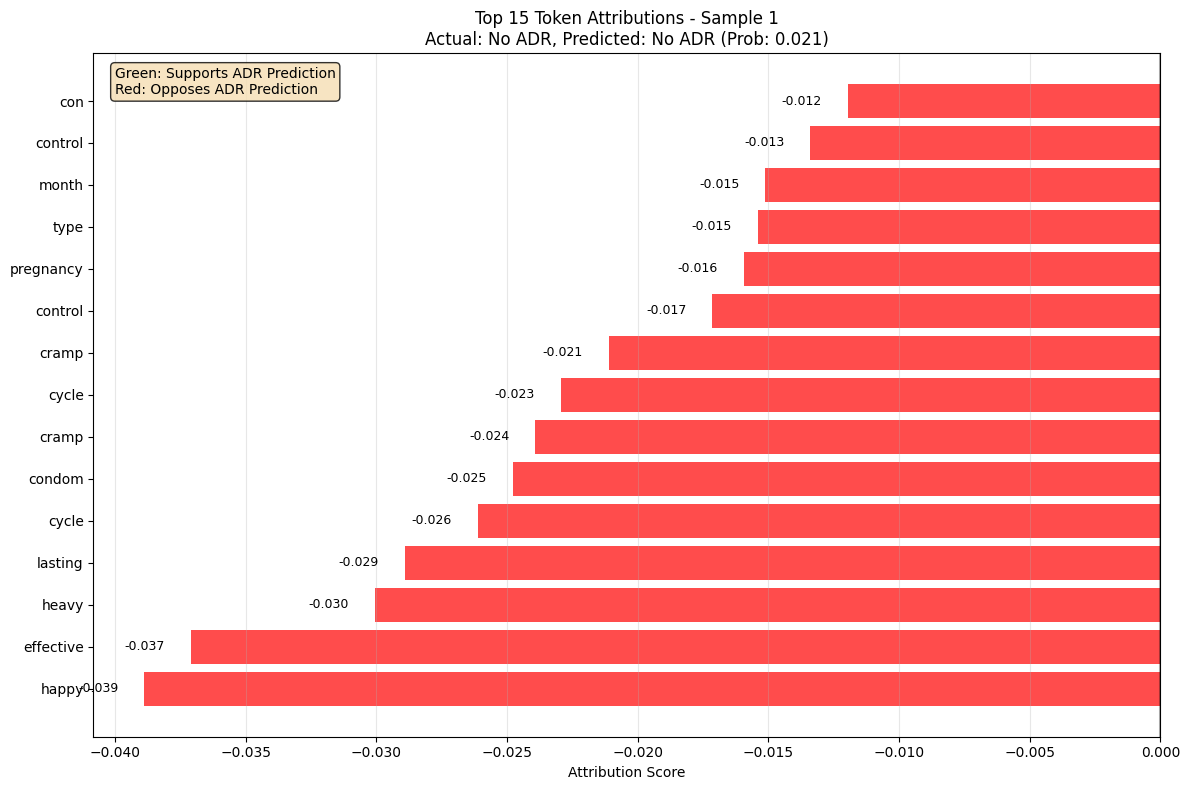


Attribution Summary:
  Total tokens analyzed: 45
  Positive attributions (support ADR): 8
  Negative attributions (oppose ADR): 37
  Average positive attribution: 0.0030
  Average negative attribution: -0.0123


In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

def integrated_gradients(inputs_emb, sub_model, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(inputs_emb).astype(np.float32)

    interpolated_inputs = [baseline + (float(i) / steps) * (inputs_emb - baseline) for i in range(steps + 1)]
    grads = []
    for x in interpolated_inputs:
        x = tf.convert_to_tensor(x)
        with tf.GradientTape() as tape:
            tape.watch(x)
            pred = sub_model(x)
        grad = tape.gradient(pred, x)
        if grad is not None:
            grads.append(grad.numpy())
        else:
            grads.append(np.zeros_like(x.numpy()))

    avg_grads = np.average(grads[:-1], axis=0)
    integrated_grads = (inputs_emb - baseline) * avg_grads
    return integrated_grads

# Choosing the sample at index 1
idx = 1
text = df["lemmatized_review"].iloc[idx]
actual_label = df["ADR_Label"].iloc[idx]

seq = tokenizer.texts_to_sequences([text])
padded_seq = pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')
print(f"Analyzing sample {idx}:")
print(f"Text: {text[:200]}...")

# Getting embedding layer and remaining model
embedding_layer = model.layers[0]
rest_of_model = tf.keras.Sequential(model.layers[1:])

# Getting embedding vectors (shape: 1 x maxlen x embedding_dim)
embedding_weights = embedding_layer.get_weights()[0]
inputs_emb = embedding_weights[padded_seq]

# Getting model prediction
model_pred = model.predict(padded_seq, verbose=0)
predicted_class = 1 if model_pred[0][0] > best_threshold else 0
print(f"Prediction probability: {model_pred[0][0]:.3f}")

# Computing Integrated Gradients
print("Computing Integrated Gradients...")
ig_attributions = integrated_gradients(inputs_emb, rest_of_model, baseline=np.zeros_like(inputs_emb))

# Summing attributions across embedding dimensions
token_attributions = ig_attributions.sum(axis=2).flatten()

# Mapping back to tokens
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
tokens = [reverse_word_index.get(i, '<PAD>') for i in padded_seq[0]]

# Filtering out padding tokens and getting top attributions
valid_data = [(token, attr) for token, attr in zip(tokens, token_attributions)
              if token != '<PAD>' and attr != 0]

if len(valid_data) == 0:
    print("No valid tokens found!")
else:
    valid_tokens, valid_attributions = zip(*valid_data)

    # Displaying top attributions
    print(f"\nTop token attributions:")
    sorted_data = sorted(valid_data, key=lambda x: abs(x[1]), reverse=True)
    for token, score in sorted_data[:15]:
        direction = "→ ADR" if score > 0 else "→ No ADR"
        print(f"  '{token}': {score:.4f} {direction}")

    # Bar Plot Visualization
    plt.figure(figsize=(12, 8))

    # Getting top 15 tokens by absolute attribution
    top_15 = sorted_data[:15]
    top_tokens = [item[0] for item in top_15]
    top_attrs = [item[1] for item in top_15]

    colors = ['green' if attr > 0 else 'red' for attr in top_attrs]
    bars = plt.barh(range(len(top_tokens)), top_attrs, color=colors, alpha=0.7)
    plt.yticks(range(len(top_tokens)), top_tokens)
    plt.xlabel('Attribution Score')
    plt.title(f'Top 15 Token Attributions - Sample {idx}\n'
              f'Actual: {"ADR" if actual_label else "No ADR"}, '
              f'Predicted: {"ADR" if predicted_class else "No ADR"} '
              f'(Prob: {model_pred[0][0]:.3f})')
    for i, (bar, val) in enumerate(zip(bars, top_attrs)):
        plt.text(val + (0.001 if val >= 0 else -0.001), i, f'{val:.3f}',
                va='center', ha='left' if val >= 0 else 'right', fontsize=9)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.text(0.02, 0.98, 'Green: Supports ADR Prediction\nRed: Opposes ADR Prediction',
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    positive_attrs = [attr for attr in valid_attributions if attr > 0]
    negative_attrs = [attr for attr in valid_attributions if attr < 0]

    print(f"\nAttribution Summary:")
    print(f"  Total tokens analyzed: {len(valid_attributions)}")
    print(f"  Positive attributions (support ADR): {len(positive_attrs)}")
    print(f"  Negative attributions (oppose ADR): {len(negative_attrs)}")
    print(f"  Average positive attribution: {np.mean(positive_attrs):.4f}" if positive_attrs else "  No positive attributions")
    print(f"  Average negative attribution: {np.mean(negative_attrs):.4f}" if negative_attrs else "  No negative attributions")

SHAP

In [38]:
import shap
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sampling 100 background texts from the DataFrame
background_texts = df["lemmatized_review"].sample(100, random_state=42).tolist()

# Converting background texts to token sequences and padding them
background_sequences = tokenizer.texts_to_sequences(background_texts)
background_padded = pad_sequences(background_sequences, maxlen=200)

# Defining the prediction function that takes numeric padded input
def f(padded_sequences):
    preds = model.predict(padded_sequences)
    return preds.flatten()

# Initializing SHAP KernelExplainer with numeric background data
explainer = shap.KernelExplainer(f, background_padded)

# Pick the sample at index 0
idx = 0
text_instance = df["lemmatized_review"].iloc[idx]

# Converting this text to padded sequence (model input format)
text_seq = tokenizer.texts_to_sequences([text_instance])
text_padded = pad_sequences(text_seq, maxlen=200)

# Getting SHAP values for this one input (text_padded shape = (1, 200))
shap_values = explainer.shap_values(text_padded)

# Visualizing the SHAP explanation
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    text_padded[0].astype(float)
)




4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
7650/7650 ━━━━━━━━━━━━━━━━━━━━ 1390s 182ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 184ms/step


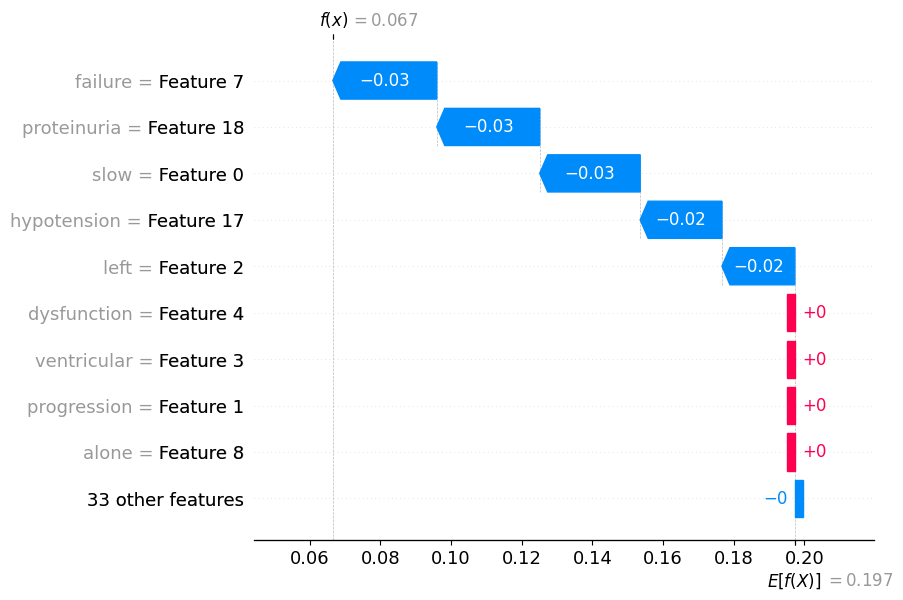

In [39]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Choosing the instance at index 0 to explain
instance_index_to_explain = 0
text_instance = df["lemmatized_review"].iloc[instance_index_to_explain]

# Converting this text to padded sequence (model input format)
text_seq = tokenizer.texts_to_sequences([text_instance])
text_padded = pad_sequences(text_seq, maxlen=200)

# Getting SHAP values
shap_values = explainer.shap_values(text_padded, nsamples=100)

# Converting tokens back to words for visualization
index_word = {v: k for k, v in tokenizer.word_index.items()}
word_tokens = [index_word.get(i, '[UNK]') for i in text_padded[0]]

valid_token_mask = text_padded[0] != 0
words = np.array(word_tokens)[valid_token_mask]
shap_vals = shap_values[0][valid_token_mask]

# Creating a SHAP Explanation object
explanation = shap.Explanation(values=shap_vals,
                                 base_values=explainer.expected_value,
                                 data=words)
# Generating the waterfall plot
shap.initjs()
shap.plots.waterfall(explanation)

Evaluation

In [40]:
# Faithfulness and Complexity Functions
def faithfulness(model, x, explanations, num_features_to_remove=5):
    """
    Measure faithfulness by removing top features and checking prediction change
    """
    # Handling different model types
    if hasattr(model, 'predict_proba'):  # Random Forest
        if hasattr(x, 'toarray'):
            x = x.toarray()
        original_pred = model.predict_proba(x.reshape(1, -1) if x.ndim == 1 else x)[0]
    else:  # LSTM
        original_pred = model.predict(x, verbose=0)[0]

    # Getting top features by absolute importance
    top_indices = np.argsort(np.abs(explanations))[-num_features_to_remove:]

    # Creating modified input with top features set to 0
    x_modified = x.copy()
    if hasattr(x_modified, 'toarray'):
        x_modified = x_modified.toarray()

    if x_modified.ndim == 1:
        x_modified[top_indices] = 0
        x_modified = x_modified.reshape(1, -1)
    else:
        x_modified[0, top_indices] = 0

    # Getting modified prediction
    if hasattr(model, 'predict_proba'):  # Random Forest
        modified_pred = model.predict_proba(x_modified)[0]
    else:  # LSTM
        modified_pred = model.predict(x_modified, verbose=0)[0]

    # Calculating faithfulness as prediction change
    if len(original_pred.shape) > 0 and len(original_pred) > 1:  # Multi-class
        faithfulness_score = np.abs(original_pred[1] - modified_pred[1])  # ADR class
    else:  # Binary single output
        faithfulness_score = np.abs(original_pred - modified_pred)

    return float(faithfulness_score.item() if hasattr(faithfulness_score, 'item') else faithfulness_score)

def complexity(explanations, threshold=1e-6):
    """
    Count non-zero features above threshold
    """
    return int(np.sum(np.abs(explanations) > threshold))

def fidelity(model, x, explanations, baseline_pred=None):
    """
    Measure how well explanations approximate model behavior
    """
    if baseline_pred is None:
        if hasattr(model, 'predict_proba'):
            baseline_pred = 0.5  # Default for binary classification
        else:
            baseline_pred = 0.0

    # Sum of explanations should approximate prediction difference from baseline
    explanation_sum = float(np.sum(explanations))

    # Getting actual prediction
    if hasattr(model, 'predict_proba'):  # Random Forest
        if hasattr(x, 'toarray'):
            x = x.toarray()
        actual_pred = model.predict_proba(x.reshape(1, -1) if x.ndim == 1 else x)[0]
        if len(actual_pred) > 1:
            actual_pred = float(actual_pred[1])  # ADR class
    else:  # LSTM
        actual_pred = model.predict(x, verbose=0)[0]
        if len(actual_pred.shape) > 0:
            actual_pred = float(actual_pred[0])

    fidelity_score = abs(explanation_sum - (actual_pred - baseline_pred))
    return float(fidelity_score.item() if hasattr(fidelity_score, 'item') else fidelity_score)

# LIME for LSTM Model (text-based)
from lime.lime_text import LimeTextExplainer

# Creating LIME text explainer for LSTM
lime_text_explainer = LimeTextExplainer(class_names=['No ADR', 'ADR'])

i = 0  # Sample index
text_instance = df["lemmatized_review"].iloc[i]

# Using the existing prediction function from your code
lime_exp_obj = lime_text_explainer.explain_instance(
    text_instance,
    predict_proba_enhanced_lstm,
    num_features=10
)

# Extracting LIME explanation as array (map to token positions)
tokens = text_instance.split()
lime_exp = np.zeros(len(tokens))
feature_dict = dict(lime_exp_obj.as_list())

for j, token in enumerate(tokens):
    if token in feature_dict:
        lime_exp[j] = feature_dict[token]

# Calculating metrics for LIME
lime_faith = faithfulness(model, X_test_seq[i:i+1], lime_exp)
lime_comp = complexity(lime_exp)
lime_fid = fidelity(model, X_test_seq[i:i+1], lime_exp)

print(f"LIME - Faithfulness: {float(lime_faith):.4f}, Fidelity: {float(lime_fid):.4f}, Complexity: {int(lime_comp)}")

# SHAP for LSTM Model
import shap

# Converting background sequences for SHAP
background_sequences = tokenizer.texts_to_sequences(df["lemmatized_review"].sample(100, random_state=42).tolist())
background_padded = pad_sequences(background_sequences, maxlen=maxlen)

# SHAP explainer for LSTM
def lstm_predict_fn(x):
    return model.predict(x, verbose=0).flatten()

shap_explainer = shap.KernelExplainer(lstm_predict_fn, background_padded)
shap_values = shap_explainer.shap_values(X_test_seq[i:i+1], nsamples=100)

# Getting SHAP explanation
shap_exp = shap_values[0] if isinstance(shap_values, list) else shap_values[0]

# Calculating metrics for SHAP
shap_faith = faithfulness(model, X_test_seq[i:i+1], shap_exp)
shap_comp = complexity(shap_exp)
shap_fid = fidelity(model, X_test_seq[i:i+1], shap_exp, baseline_pred=shap_explainer.expected_value)

print(f"SHAP - Faithfulness: {float(shap_faith):.4f}, Fidelity: {float(shap_fid):.4f}, Complexity: {int(shap_comp)}")

# Integrated Gradients
ig_exp = token_attributions

# Calculating metrics for Integrated Gradients
ig_faith = faithfulness(model, padded_seq, ig_exp)
ig_comp = complexity(ig_exp)
ig_fid = fidelity(model, padded_seq, ig_exp)

print(f"Integrated Gradients - Faithfulness: {ig_faith:.4f}, Fidelity: {ig_fid:.4f}, Complexity: {ig_comp}")

# TreeInterpreter for Random Forest
instance_index = 0
class_idx = 1  # ADR class
tree_exp = contributions[instance_index][:, class_idx]

# Calculating metrics for TreeInterpreter
tree_faith = faithfulness(rf_model, X_test[instance_index], tree_exp)
tree_comp = complexity(tree_exp)
tree_fid = fidelity(rf_model, X_test[instance_index], tree_exp, baseline_pred=bias[instance_index][class_idx])

print(f"TreeInterpreter - Faithfulness: {float(tree_faith):.4f}, Fidelity: {float(tree_fid):.4f}, Complexity: {int(tree_comp)}")

# Summary comparison
print("\n" + "="*60)
print("EXPLAINABILITY METRICS COMPARISON")
print("="*60)
print(f"{'Method':<20} {'Faithfulness':<12} {'Fidelity':<10} {'Complexity':<10}")
print("-"*60)
print(f"{'LIME':<20} {float(lime_faith):<12.4f} {float(lime_fid):<10.4f} {int(lime_comp):<10}")
print(f"{'SHAP':<20} {float(shap_faith):<12.4f} {float(shap_fid):<10.4f} {int(shap_comp):<10}")
print(f"{'Integrated Grad':<20} {float(ig_faith):<12.4f} {float(ig_fid):<10.4f} {int(ig_comp):<10}")
print(f"{'TreeInterpreter':<20} {float(tree_faith):<12.4f} {float(tree_fid):<10.4f} {int(tree_comp):<10}")

LIME - Faithfulness: 0.0004, Fidelity: 0.2208, Complexity: 13


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP - Faithfulness: 0.0099, Fidelity: 0.0000, Complexity: 10
Integrated Gradients - Faithfulness: 0.0378, Fidelity: 0.9421, Complexity: 200
TreeInterpreter - Faithfulness: 0.0700, Fidelity: 0.0000, Complexity: 1606

EXPLAINABILITY METRICS COMPARISON
Method               Faithfulness Fidelity   Complexity
------------------------------------------------------------
LIME                 0.0004       0.2208     13        
SHAP                 0.0099       0.0000     10        
Integrated Grad      0.0378       0.9421     200       
TreeInterpreter      0.0700       0.0000     1606      
